In [1]:
from linares_plot import *
from missdirection_model import *
%load_ext autoreload
%autoreload



In [7]:
n_simulations =50
numcores = multiprocessing.cpu_count() - 1

### Standard

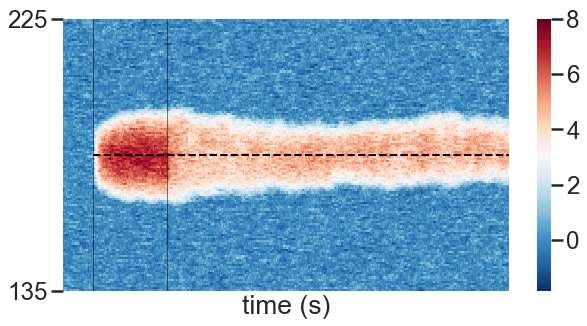

4.300404816058091

In [213]:
an = model(totalTime=1500, targ_onset=100, angle_target_i=180, presentation_period=250, angle_separation=22, tauE=9, tauI=4,  n_stims=1, 
     I0E=0.1, I0I=0.5, GEE=0.025, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, kappa_E=300, kappa_I=30, 
     kappa_stim=75, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False) 

abs_180_bias = an[0] ## 180-decode_rE(RE) measured that way
abs_180_bias

### Direction

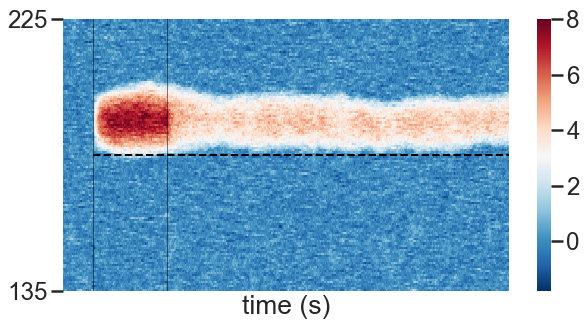

14.18354579699482 False


In [134]:
an = model(totalTime=1500, targ_onset=100, angle_target_i=192, presentation_period=250, angle_separation=30, tauE=9, tauI=4,  n_stims=1, 
     I0E=0.1, I0I=0.5, GEE=0.024, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, kappa_E=300, kappa_I=30, 
     kappa_stim=150, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False) 

abs_180_bias = an[0] ## 180-decode_rE(RE) measured that way
active = an[2]
print(abs_180_bias, active)

In [140]:
results = Parallel(n_jobs = numcores)(delayed(model)(totalTime=1500, targ_onset=100, angle_target_i=192, presentation_period=250, angle_separation=30, tauE=9, 
               tauI=4,  n_stims=1, I0E=0.1, I0I=0.5, GEE=0.024, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, 
               kappa_E=300, kappa_I=30, kappa_stim=150, N=512, plot_connectivity=False, plot_rate=False, 
               plot_hm=False , plot_fit=False) for i in range(0,n_simulations)) 


bias_direction = [results[i][0] for i in range(len(results))]
active_direction = [results[i][2] for i in range(len(results))]

In [141]:
print( 'Mean abs bias: ' +str(np.round(np.mean(bias_direction),2)) + ', detected: ' +str(np.sum(active_direction)*100/n_simulations ) + '%' )


Mean abs bias: 11.73, detected: 10.0%


angle_target_i=192: 12%   
angle_target_i=195: 0%   




### Diminishment

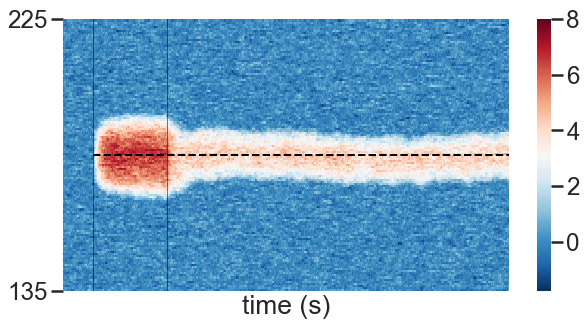

6.5480300620308185 True


In [108]:
an = model(totalTime=1500, targ_onset=100, angle_target_i=180, presentation_period=250, angle_separation=22, tauE=9, tauI=4, 
           n_stims=1, I0E=0, I0I=0.5, GEE=0.024, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, kappa_E=300, kappa_I=30, 
           kappa_stim=75, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False) 

abs_180_bias = an[0] ## 180-decode_rE(RE) measured that way
active = an[2]
print(abs_180_bias, active)

In [ ]:
results = Parallel(n_jobs = numcores)(delayed(model)(totalTime=1500, targ_onset=100, angle_target_i=180, presentation_period=250, angle_separation=22, tauE=9, tauI=4, 
               n_stims=1, I0E=-0.25, I0I=0.5, GEE=0.025, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, kappa_E=300, kappa_I=30, 
               kappa_stim=75, N=512, plot_connectivity=False, plot_rate=False, plot_hm=False , plot_fit=False) for i in range(0,n_simulations)) 


bias_diminish = [results[i][0] for i in range(len(results))]
active_diminish = [results[i][2] for i in range(len(results))]

In [ ]:
print( 'Mean abs bias: ' +str(np.round(np.mean(bias_diminish),2)) + ', detected: ' +str(np.sum(active_diminish)*100/n_simulations ) + '%' )



I0E=-0.25: detected 14%  
I0E= = -0.24 : detected 28%  
I0E = -0.23 : detected 63%  
I0E= -0.22: detected 70%  
I0E = -0.21: detected 84%  
I0E = -0.20: detected 88%  

### Division

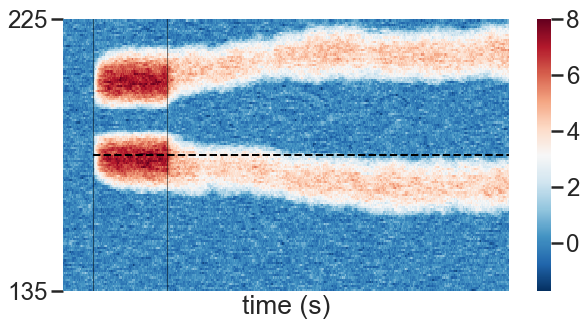

9.291256747169854 False 2


In [142]:
an = model(totalTime=1500, targ_onset=100, angle_target_i=180, presentation_period=250, angle_separation=24, tauE=9, tauI=4, 
           n_stims=2, I0E=0.1, I0I=0.5, GEE=0.024, GEI=0.019, GIE=0.01 , GII=0.1, sigE=1.1, sigI=1.9, kappa_E=300, kappa_I=30,
           kappa_stim=150, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False) 

abs_180_bias = an[0] ## 180-decode_rE(RE) measured that way
active = an[2]
n_bumps=an[8]
print(abs_180_bias, active, n_bumps)

In [147]:
results = Parallel(n_jobs = numcores)(delayed(model)(totalTime=1500, targ_onset=100, angle_target_i=180, 
                                                     presentation_period=250, angle_separation=25, tauE=9, tauI=4, 
                                                     n_stims=2, I0E=0.1, I0I=0.5, GEE=0.024, GEI=0.019, GIE=0.01 , 
                                                     GII=0.1, sigE=1.1, sigI=1.9, kappa_E=300, kappa_I=30, 
                                                     kappa_stim=150, N=512, plot_connectivity=False, plot_rate=False, 
                                                     plot_hm=True , plot_fit=False) for i in range(0,n_simulations)) 


bias_division = [results[i][0] for i in range(len(results))]
active_division = [results[i][2] for i in range(len(results))]
number_bumps = [results[i][8] for i in range(len(results))]

In [148]:
print( 'Mean abs bias: ' +str(np.round(np.mean(bias_division),2)) + ', detected: ' +str(np.sum(active_division)*100/n_simulations ) + '%' )


Mean abs bias: 10.63, detected: 10.0%


sep=26 : 38%  
sep= 25: 10%  
sep= 24: 4%  
sep= 22: 2%  

In [85]:
Direct = pd.DataFrame(active_direction)
Direct['type']='direction'
Direct.columns=['detection', 'type']

Diminish = pd.DataFrame(active_diminish)
Diminish['type']='diminish'
Diminish.columns=['detection', 'type']

Division = pd.DataFrame(active_division)
Division['type']='division'
Division.columns=['detection', 'type']

df = pd.concat([Direct, Diminish, Division ])


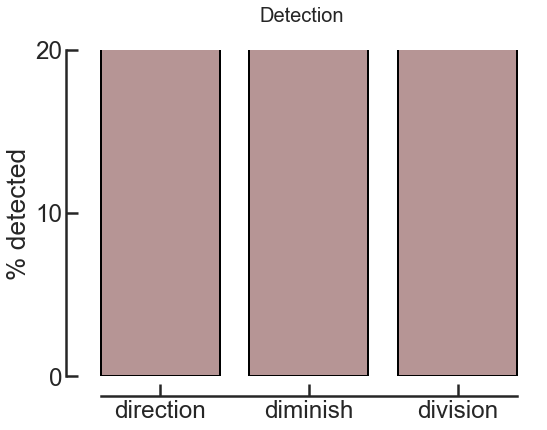

In [139]:
fig = plt.figure()
fig.set_size_inches(8,6)
fig.suptitle('Detection', fontsize=20)
g = sns.barplot(x="type", y="detection", data=df, estimator=np.mean, order=['direction', 'diminish', 'division' ], 
            ci=None,  color='rosybrown',  edgecolor='black', ecolor='k')

g.set_ylim(0,0.2);
plt.xlabel('')
plt.ylabel('% detected')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(direction='in') #direction
plt.gca().set_yticks([0, 0.1, 0.2])
plt.gca().set_yticklabels([0, 10, 20])
adjust_spines(plt.gca(), ['left', 'bottom'])